<a href="https://colab.research.google.com/github/Kryptera-K/AXON-Blue-Impulse-Oversold-Strategy-BIOS-/blob/main/AXON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "AXON"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("AXON_clean.csv", index=False)
df

/tmp/ipython-input-2918707462.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2001-06-19,0.460000,0.508333,0.460000,0.508333,237600
2001-06-20,0.445833,0.458333,0.445833,0.458333,56400
2001-06-21,0.445833,0.445833,0.445833,0.445833,7200
2001-06-22,0.479167,0.479167,0.445833,0.445833,142800
2001-06-25,0.479167,0.483333,0.475000,0.479167,92400
...,...,...,...,...,...
2025-12-04,550.609985,553.460022,540.650024,547.489990,1259100
2025-12-05,550.950012,556.000000,544.809998,551.020020,389500
2025-12-08,553.119995,555.380005,548.219971,553.700012,533200


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

EIS_EMA_PERIOD = 13
EIS_MACD_FAST = 12
EIS_MACD_SIGNAL = 9
EIS_MACD_SLOW = 26
RSI_OVERSOLD_LEVEL = 30
RSI_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------

def elder_is_blue(df):
    df = calculate_elder_impulse(df)
    return ~(elder_is_green(df) | elder_is_red(df))


def calculate_elder_impulse(df, ema_period=EIS_EMA_PERIOD, macd_fast=EIS_MACD_FAST, macd_slow=EIS_MACD_SLOW, macd_signal=EIS_MACD_SIGNAL):
    df = df.copy()

    ema = df['Close'].ewm(span=ema_period).mean()
    macd = df['Close'].ewm(span=macd_fast).mean() - df['Close'].ewm(span=macd_slow).mean()
    macd_signal = macd.ewm(span=macd_signal).mean()
    macd_hist = macd - macd_signal

    df['EMA_Slope'] = ema.diff()
    df['MACD_Hist_Slope'] = macd_hist.diff()

    return df


def elder_is_green(df):
    df = calculate_elder_impulse(df)
    return (df['EMA_Slope'] > 0) & (df['MACD_Hist_Slope'] > 0)


def elder_is_red(df):
    df = calculate_elder_impulse(df)
    return (df['EMA_Slope'] < 0) & (df['MACD_Hist_Slope'] < 0)


def rsi_lower_than_os(df, level=RSI_OVERSOLD_LEVEL):
    df = calculate_rsi(df)
    return df['RSI'] < level


def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df



# -------------------------
# Entry conditions
# -------------------------

df["EIS_Is_Blue"] = elder_is_blue(df)

# -------------------------
# Exit conditions
# -------------------------

df["RSI_Lower_Than_OS"] = rsi_lower_than_os(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'EIS_Is_Blue',
]
exit_conditions = [
    'RSI_Lower_Than_OS',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2001-06-19 00:00:00
End                                  2025-12-10 00:00:00
Period                                6157 days 00:00:00
Start Value                                     100000.0
End Value                               159183742.988982
Total Return [%]                           159083.742989
Benchmark Return [%]                       108549.243323
Max Gross Exposure [%]                             100.0
Total Fees Paid                           7509777.286703
Max Drawdown [%]                                87.53825
Max Drawdown Duration                 3489 days 00:00:00
Total Trades                                         172
Total Closed Trades                                  171
Total Open Trades                                      1
Open Trade PnL                            5529306.422866
Win Rate [%]                                   32.163743
Best Trade [%]                               4089.772722
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2001-06-19 00:00:00
End                           2025-12-10 00:00:00
Period                         6157 days 00:00:00
Start Value                              100000.0
End Value                        108649243.323465
Total Return [%]                    108549.243323
Benchmark Return [%]                108549.243323
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         91.46789
Max Drawdown Duration          2600 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                   108549243.323465
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1795505579.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


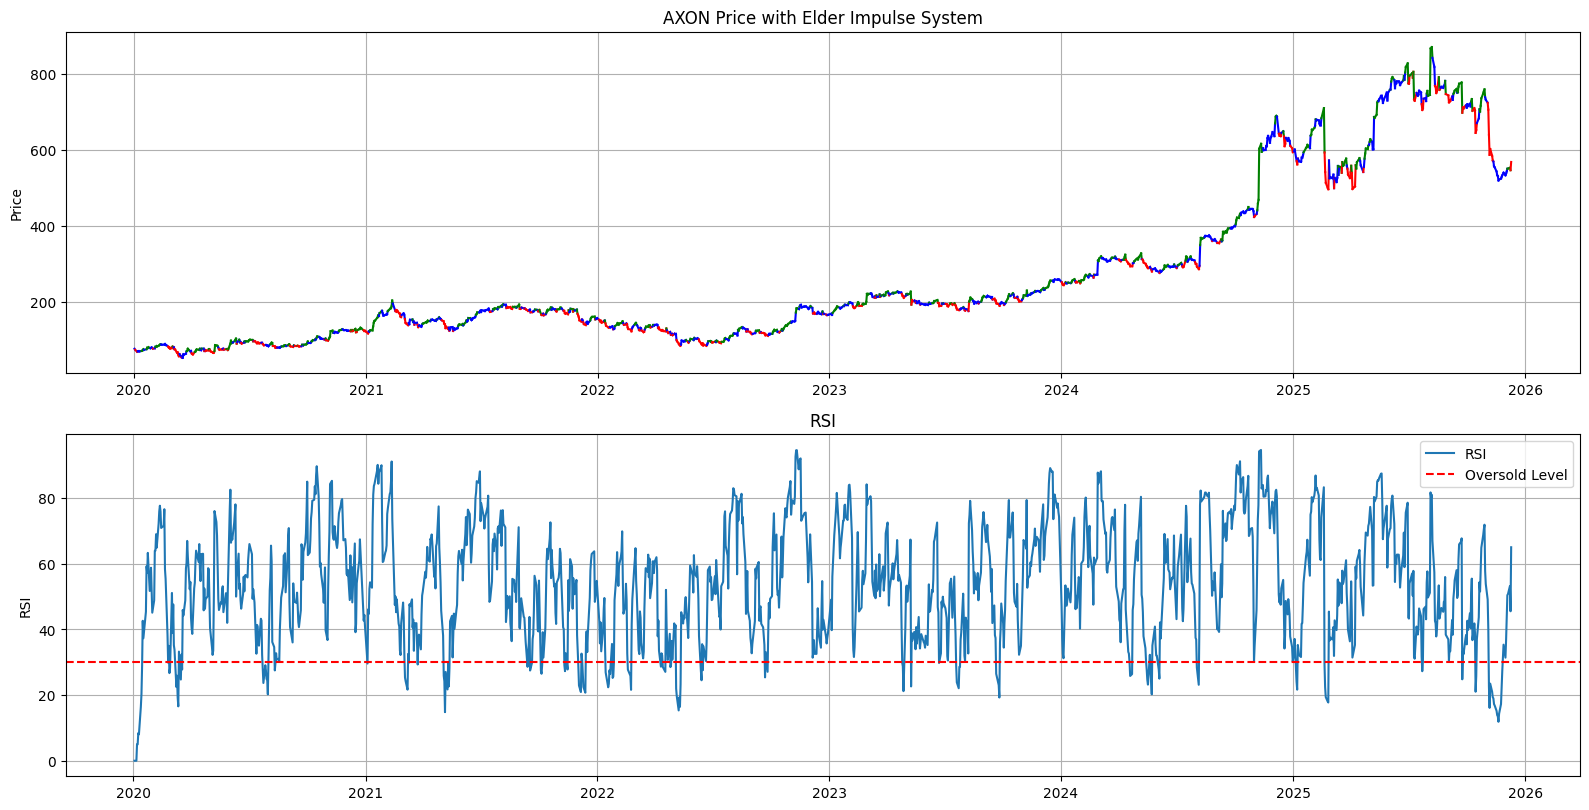

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "AXON"
start_date = "2020-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Necessary Parameters
# -------------------------
EIS_EMA_PERIOD = 13
EIS_MACD_FAST = 12
EIS_MACD_SIGNAL = 9
EIS_MACD_SLOW = 26
RSI_OVERSOLD_LEVEL = 30
RSI_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------

def calculate_elder_impulse(df):
    ema = df['Close'].ewm(span=EIS_EMA_PERIOD).mean()
    macd = df['Close'].ewm(span=EIS_MACD_FAST).mean() - df['Close'].ewm(span=EIS_MACD_SLOW).mean()
    macd_signal = macd.ewm(span=EIS_MACD_SIGNAL).mean()
    macd_hist = macd - macd_signal

    df['EMA_Slope'] = ema.diff()
    df['MACD_Hist_Slope'] = macd_hist.diff()
    return df

def elder_is_green(df):
    return (df['EMA_Slope'] > 0) & (df['MACD_Hist_Slope'] > 0)

def elder_is_red(df):
    return (df['EMA_Slope'] < 0) & (df['MACD_Hist_Slope'] < 0)

def elder_is_blue(df):
    return ~(elder_is_green(df) | elder_is_red(df))

def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

# -------------------------
# Compute Indicators
# -------------------------
df = calculate_elder_impulse(df)
df = calculate_rsi(df)

df["Green"] = elder_is_green(df)
df["Red"] = elder_is_red(df)
df["Blue"] = elder_is_blue(df)

# -------------------------
# Plotting
# -------------------------

fig = plt.figure(figsize=(16, 12))

# -------- Price + Elder Impulse Colors --------
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_title("AXON Price with Elder Impulse System")

for i in range(len(df)):
    color = "green" if df["Green"].iloc[i] else ("red" if df["Red"].iloc[i] else "blue")
    ax1.plot(df.index[i:i+2], df["Close"].iloc[i:i+2], color=color)

ax1.grid(True)
ax1.set_ylabel("Price")

# -------- RSI --------
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(df.index, df["RSI"], label="RSI")
ax2.axhline(RSI_OVERSOLD_LEVEL, color="red", linestyle="--", label="Oversold Level")
ax2.set_title("RSI")
ax2.set_ylabel("RSI")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
